In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST
import numpy as np
from PIL import Image

In [2]:
dataset = MNIST(root = 'data/', download = True)


C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
len(dataset)

60000

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

5


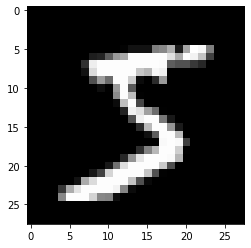

In [5]:
image, label = dataset[0]
plt.imshow(image, cmap = 'gray')
print(label)

In [6]:
import torchvision.transforms as transforms

In [7]:
dataset = MNIST(root = 'data/', train = True, transform= transforms.ToTensor())
test_dataset = MNIST(root = 'data/', train = False, transform= transforms.ToTensor())

In [8]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


In [9]:
print(img_tensor[:, 10:15,10:15])

tensor([[[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
         [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
         [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
         [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
         [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]]])


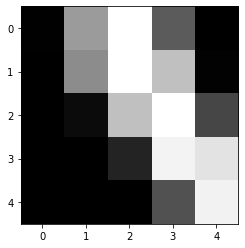

In [10]:
plt.imshow(img_tensor[0,10:15,10:15], cmap='gray')

In [11]:
from torch.utils.data import random_split

train_ds , valid_ds = random_split(dataset, [50000,10000])

len(train_ds), len(valid_ds)

(50000, 10000)

In [12]:
from torch.utils.data import DataLoader

batch_size = 128

train_dl = DataLoader(train_ds, batch_size, shuffle= True)
valid_dl = DataLoader(valid_ds, batch_size)

In [13]:
import torch.nn as nn

input_size = 28*28
num_classes = 10

model = nn.Linear(input_size, num_classes)

In [14]:
print(model.weight.shape)

torch.Size([10, 784])


In [15]:
print(model.bias.shape)

torch.Size([10])


In [16]:
for image, label in train_dl:
    print(label)
    break

tensor([8, 5, 6, 7, 3, 5, 2, 9, 3, 3, 7, 5, 6, 6, 4, 5, 6, 8, 9, 0, 3, 8, 4, 0,
        5, 3, 2, 7, 4, 6, 4, 2, 0, 0, 4, 7, 0, 3, 7, 2, 3, 5, 5, 4, 8, 6, 3, 9,
        2, 4, 2, 7, 5, 6, 6, 2, 8, 1, 8, 4, 5, 7, 1, 1, 5, 3, 0, 2, 5, 2, 9, 7,
        0, 5, 1, 0, 5, 5, 1, 0, 0, 8, 7, 8, 4, 1, 9, 2, 4, 1, 6, 8, 3, 6, 3, 4,
        5, 8, 1, 1, 0, 1, 1, 8, 7, 8, 5, 7, 1, 2, 0, 8, 2, 5, 4, 6, 6, 3, 1, 3,
        6, 4, 4, 6, 5, 4, 3, 6])


In [17]:
image.shape

torch.Size([128, 1, 28, 28])

In [18]:
image.reshape(128,784).shape

torch.Size([128, 784])

In [19]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self,xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out

model = MnistModel()

In [20]:
for images, labels in train_dl:
    print(images.shape)
    output = model(images)
    break


torch.Size([128, 1, 28, 28])


In [21]:
import torch.nn.functional as F    

In [22]:
probs = F.softmax(output, dim=1)

max_probs, preds = torch.max(probs, dim=1)


In [23]:
def accuracy(outputs,labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item()/ len(preds))


In [24]:
accuracy(output, labels)

tensor(0.1406)

In [25]:
loss_fn = F.cross_entropy

In [26]:
loss = loss_fn(output, labels)
print(loss)

tensor(2.3338, grad_fn=<NllLossBackward>)


In [27]:
def fit(epochs, lr, model, train_dl, valid_dl, opt_func = torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = []
    
    for epoch in range(epochs):
        for batch in train_dl:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, valid_dl)
        model.epoch_end(epoch, result)
        history.append(result)
    return history
    

In [28]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [29]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self,batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss, 'val_acc' : acc}
    
    def weights(self):
        return self.linear.weight
    
    def bias(self):
        return self.linear.bias
    
    def validation_epoch_end(self, output):
        batch_losses = [x['val_loss'] for x in output]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in output]
        epoch_acc = torch.stack(batch_accs).mean()
        
        return {'val_loss': epoch_loss, 'val_acc': epoch_acc}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch+1, result['val_loss'], result['val_acc']))

model = MnistModel()

In [30]:
history1 = fit(10, 0.001, model, train_dl, valid_dl)

Epoch [1], val_loss: 1.9511, val_acc: 0.6021
Epoch [2], val_loss: 1.6821, val_acc: 0.7236
Epoch [3], val_loss: 1.4803, val_acc: 0.7683
Epoch [4], val_loss: 1.3275, val_acc: 0.7908
Epoch [5], val_loss: 1.2098, val_acc: 0.8027
Epoch [6], val_loss: 1.1170, val_acc: 0.8114
Epoch [7], val_loss: 1.0426, val_acc: 0.8191
Epoch [8], val_loss: 0.9816, val_acc: 0.8253
Epoch [9], val_loss: 0.9308, val_acc: 0.8293
Epoch [10], val_loss: 0.8878, val_acc: 0.8339


In [31]:
history2 = fit(10, 0.01, model, train_dl, valid_dl)


Epoch [1], val_loss: 0.6630, val_acc: 0.8582
Epoch [2], val_loss: 0.5709, val_acc: 0.8687
Epoch [3], val_loss: 0.5190, val_acc: 0.8761
Epoch [4], val_loss: 0.4852, val_acc: 0.8807
Epoch [5], val_loss: 0.4607, val_acc: 0.8839
Epoch [6], val_loss: 0.4423, val_acc: 0.8864
Epoch [7], val_loss: 0.4278, val_acc: 0.8893
Epoch [8], val_loss: 0.4159, val_acc: 0.8912
Epoch [9], val_loss: 0.4059, val_acc: 0.8926
Epoch [10], val_loss: 0.3975, val_acc: 0.8939


In [32]:
weights, bias=list(model.parameters())
weights = weights[0]
size = (300,300)
with torch.no_grad():
    weights = weights.numpy()
    weights = np.reshape(weights, [28,28])
    img = Image.fromarray(weights * 255)
    img.resize(size)
    img.show()

In [33]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim = 1)
    return preds[0].item()
    

Label:  7 Prediction:  7


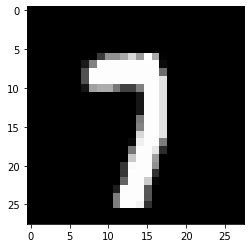

In [34]:
img, label = test_dataset[321]
plt.imshow(img[0], cmap = 'gray')
print('Label: ', label,'Prediction: ', predict_image(img, model))